# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities? 
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
8. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load in data
air = pd.read_csv('../../DS3021wrangling/assignment/data/airbnb_hw.csv')
air.head()

,Host Id,Host Since,Name,Neighbourhood,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating
0,5162530,NaN,1 Bedroom in Prime Williamsburg,Brooklyn,Apartment,NaN,Entire home/apt,11249.0,1.0,1,0,145,NaN
1,33134899,NaN,"Sunny, Private room in Bushwick",Brooklyn,Apartment,NaN,Private room,11206.0,1.0,1,1,37,NaN
2,39608626,NaN,Sunny Room in Harlem,Manhattan,Apartment,NaN,Private room,10032.0,1.0,1,1,28,NaN
3,500,6/26/2008,Gorgeous 1 BR with Private Balcony,Manhattan,Apartment,NaN,Entire home/apt,10024.0,3.0,1,0,199,NaN
4,500,6/26/2008,Trendy Times Square Loft,Manhattan,Apartment,95.0,Private room,10036.0,3.0,1,39,549,96.0


### 1. Clean the data and perform some EDA and visualization to get to know the data set.

In [3]:
print(air['Price'].isnull().sum()) # no NA values within Price
print(air['Price'].dtype) # originally a string

air['Price'] = air['Price'].str.replace(",", "") # remove the commas so I can change it to an int

air['Price'] = pd.to_numeric(air['Price']).astype('Int64') # change to an int, because price is a number and will be easier to manipulate as an int
print(air['Price'].dtype)
print(air['Price'][air['Price']>999]) # now the values with commas look good

0
object
Int64
101      1990
263      1000
764      1200
1272     1000
1275     5000
         ... 
28951    3390
28952    1356
28953    2599
28985    2000
30281    2000
Name: Price, Length: 181, dtype: Int64


In [4]:
# change some variables into ints without decimals

air['Zipcode'] = pd.to_numeric(air['Zipcode']).astype('Int64')
air['Beds'] = pd.to_numeric(air['Beds']).astype('Int64')
air['Review Scores Rating'] = pd.to_numeric(air['Review Scores Rating']).astype('Int64')

In [5]:
# where are our missing values?
air.isnull().sum()
# remove the missing values as regression doesn't work with na values
air = air.dropna()

In [6]:
air['Hosting_years'] = pd.to_datetime(air['Host Since'])

# let's calculate hosting time as a column

air['Hosting_days'] = air['Hosting_years'].max() - air['Hosting_years']

In [7]:
print(air['Hosting_days'].dtype)
air['Hosting_days'] = air['Hosting_days'].dt.days
print(air['Hosting_days'].dtype)

timedelta64[ns]
int64


In [8]:
# What is the relationship between neighborhood and property types?
pd.crosstab(air['Neighbourhood '], air['Property Type'])

Property Type,Apartment,Bed & Breakfast,Boat,Bungalow,Cabin,Camper/RV,Castle,Chalet,Condominium,Dorm,House,Hut,Lighthouse,Loft,Other,Townhouse,Treehouse,Villa
Neighbourhood,,,,,,,,,,,,,,,,,,
Bronx,130,2,0,0,0,0,0,0,1,0,76,0,0,5,0,1,0,0
Brooklyn,6979,59,1,0,0,1,0,1,17,13,908,0,1,396,9,46,1,0
Manhattan,11261,47,0,0,1,0,1,0,28,3,127,1,0,176,14,30,2,2
Queens,1124,27,5,3,1,5,0,0,2,5,378,0,0,13,4,5,0,4
Staten Island,33,1,0,0,0,0,0,0,0,0,58,0,0,0,1,1,0,0


In [9]:
# what is the relationship between neighborhood and price?

air['Price'].groupby(air['Neighbourhood ']).mean()

# seems that Manhattan is the most expensive!

Neighbourhood 
Bronx             75.195349
Brooklyn         127.773482
Manhattan        183.555375
Queens            96.813452
Staten Island    147.691489
Name: Price, dtype: Float64

In [10]:
# what is the relationship between property type and price?

air['Price'].groupby(air['Property Type']).mean()

Property Type
Apartment          153.880268
Bed & Breakfast    103.095588
Boat               153.333333
Bungalow           143.666667
Cabin                   165.0
Camper/RV           66.666667
Castle                  150.0
Chalet                   99.0
Condominium        241.229167
Dorm                65.809524
House              147.179056
Hut                      50.0
Lighthouse               39.0
Loft               203.728814
Other              178.928571
Townhouse          214.253012
Treehouse          167.666667
Villa                   154.0
Name: Price, dtype: Float64

(0.0, 1000.0)

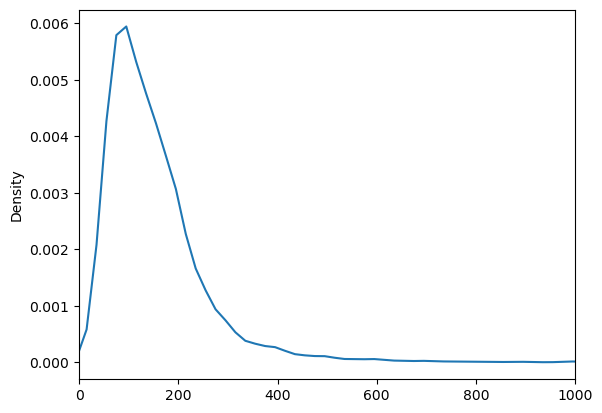

In [11]:
air['Price'].plot.density()
plt.xlim(0, 1000)

# most prices are around 100

(0.0, 2000.0)

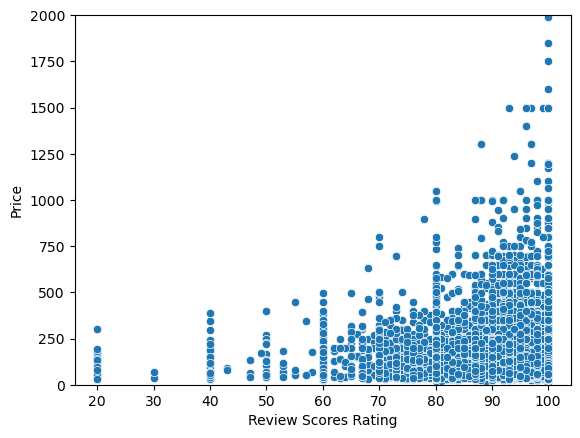

In [12]:
sns.scatterplot(x=air['Review Scores Rating'], y=air['Price'])
plt.ylim(0,2000)

# seems higher ratings have higher prices

### 2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.

In [13]:
# which are our categorical variables?
# zip code is also categorical, but is somewhat related to Neighbourhood, so I shall leave it out

air.select_dtypes(include=['object', 'category', 'string']).head(n=3)

,Host Since,Name,Neighbourhood,Property Type,Room Type
4,6/26/2008,Trendy Times Square Loft,Manhattan,Apartment,Private room
5,7/25/2008,Big Greenpoint 1BD w/ Skyline View,Brooklyn,Apartment,Entire home/apt
6,8/12/2008,Amazing Also,Manhattan,Apartment,Entire home/apt


In [14]:
vars = ['Beds', 'Number Of Reviews', 'Review Scores Rating', 'Neighbourhood ', 'Property Type', 'Room Type']
X = air.loc[:, vars]
X = pd.get_dummies(X, columns=['Neighbourhood ', 'Property Type', 'Room Type'], drop_first=True)

My arcsin transformations for numerical values will be found below at question 6.

### 3. Implement an ~80/~20 train-test split. Put the test data aside.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

In [16]:
y = air['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)


### 4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?

In [17]:
# Using the number of Beds to predict Price

X = air[['Beds']]
y = air['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)

y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

# RMSE
print(np.sqrt(mean_squared_error(y_train, y_train_pred)))
print(np.sqrt(mean_squared_error(y_test, y_test_pred)))

# R-squared
print(r2_score(y_train, y_train_pred))
print(r2_score(y_test, y_test_pred))


144.1082344895013
113.71023243023066
0.12430304077153354
0.1983909256350299


We need to look at the RMSE to see how far the predictions are to the actual values, the smaller the RMSE the closer and more accurate the model is.
R-squared shows how much of the variation in Price is explained by the number of beds (from 0 to 1, where 1 means 100% of the variance is explained).
Need to look at test values for both.

Beds to predict Price:

Test RMSE: 113.71

Test R^2: .198

It seems that not much of the variance in price is explained by the number of beds, lets try another numerical variable and then do some categorical ones.

In [18]:
# Using Review Scores Rating to predict Price

X_rsr = air[['Review Scores Rating']]
y = air['Price']

X_train, X_test, y_train, y_test = train_test_split(X_rsr, y, test_size=0.2, random_state=40)

reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)

y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

# RMSE
print(np.sqrt(mean_squared_error(y_train, y_train_pred)))
print(np.sqrt(mean_squared_error(y_test, y_test_pred)))

# R-squared
print(r2_score(y_train, y_train_pred))
print(r2_score(y_test, y_test_pred))

153.7527395801283
126.59329708605107
0.003167997539730072
0.006460924281077807


Review score rating to predict Price:

Test RMSE: 126.6

Test R^2: .006

This one performed worse as it seems that not much of the variance in price is explained by the rating, lets try some categorical variables.

In [19]:
vars = ['Neighbourhood ']
X = air.loc[:, vars]
X = pd.get_dummies(X, columns=['Neighbourhood '], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)

y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

# RMSE
print(np.sqrt(mean_squared_error(y_train, y_train_pred)))
print(np.sqrt(mean_squared_error(y_test, y_test_pred)))

# R-squared
print(r2_score(y_train, y_train_pred))
print(r2_score(y_test, y_test_pred))

150.64696499030245
122.91552573902435
0.043032872441267744
0.06335069225687484


In [20]:
vars = ['Room Type']
X = air.loc[:, vars]
X = pd.get_dummies(X, columns=['Room Type'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)

y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

# RMSE
print(np.sqrt(mean_squared_error(y_train, y_train_pred)))
print(np.sqrt(mean_squared_error(y_test, y_test_pred)))

# R-squared
print(r2_score(y_train, y_train_pred))
print(r2_score(y_test, y_test_pred))

142.7016984428359
114.02497092389493
0.1413137061386065
0.19394723760689803


For categorical variables, it seems like Room type performed slightly better than Neighborhood in the r-squared, while Neighborhood performed better in having a smaller root mean squared error.

### 5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities? 

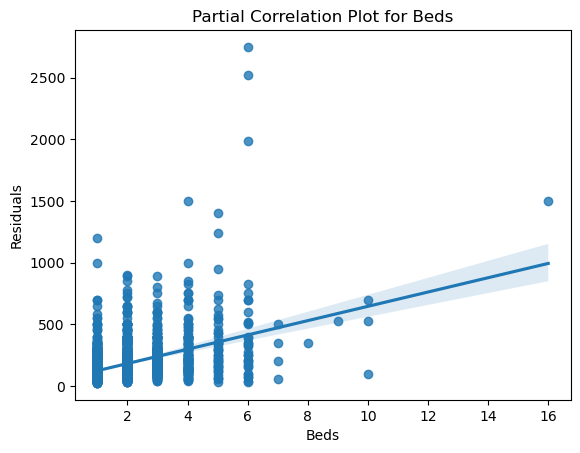

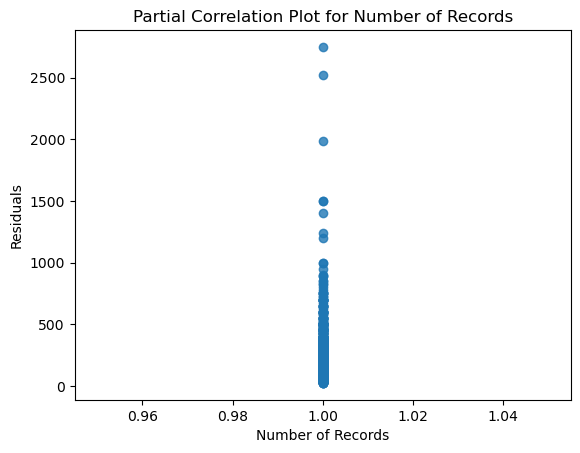

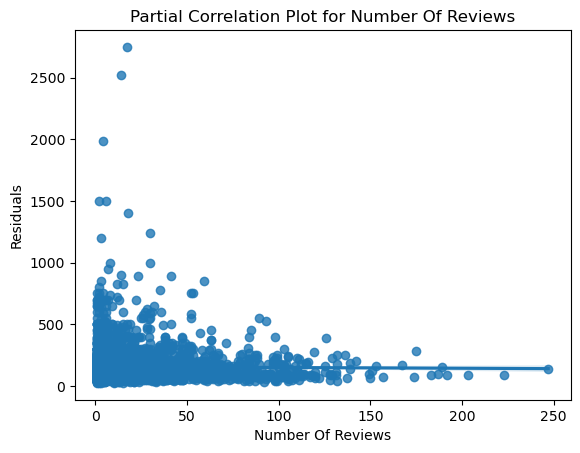

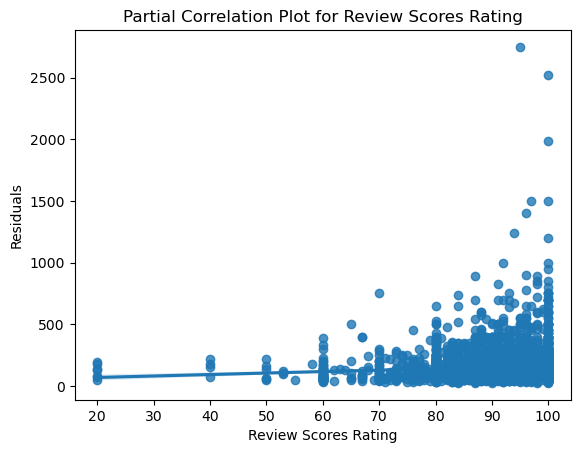

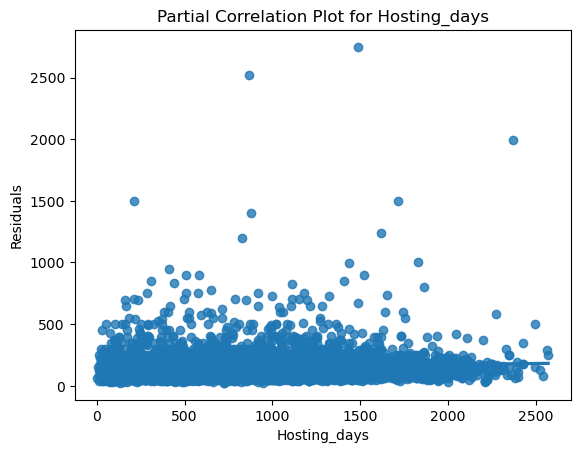

In [21]:
numeric = ['Beds', 'Number of Records', 'Number Of Reviews', 'Review Scores Rating', 'Hosting_days']
air['Hosting_days'] = air['Hosting_days'].astype('int')

for each in numeric:
    X = air[[each]]
    y = air['Price']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

    reg = LinearRegression().fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    residuals = y_test - y_pred

    sns.regplot(x=X_test, y=y_test).set(title='Partial Correlation Plot')
    plt.xlabel(each) 
    plt.ylabel("Residuals")
    plt.title(f"Partial Correlation Plot for {each}")
    plt.show()


This does not look the best. The variables should probably be transformed somehow.

### 6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?

In [22]:
# I will arcsinh transform some of the badly scaled numerics first

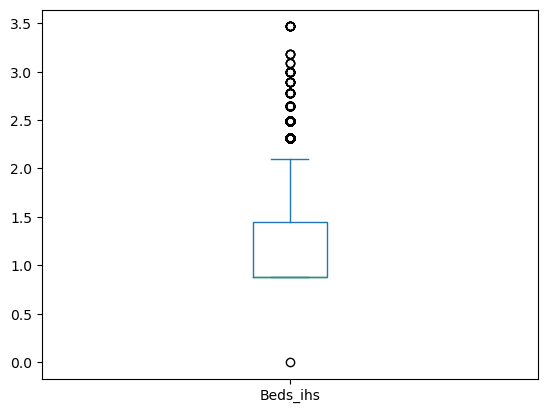

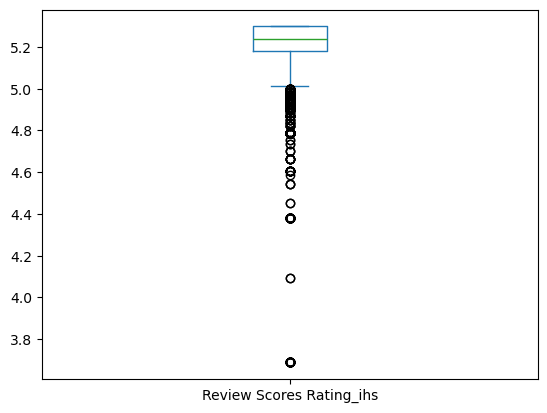

In [23]:
# arcsin so variables are on the same scale

air['Beds_ihs'] = np.arcsinh(air['Beds'])
air['Number Of Reviews_ihs'] = np.arcsinh(air['Number Of Reviews'])
air['Review Scores Rating_ihs'] = np.arcsinh(air['Review Scores Rating'])
air['Hosting_days'] = np.arcsinh(air['Hosting_days'])

air['Beds_ihs'].plot.box()
plt.show()

air['Review Scores Rating_ihs'].plot.box()
plt.show() 

In [24]:
# Create a joint model with both numerical one-hot-encoded categorical variables

y = air['Price']
vars = ['Beds_ihs', 'Number Of Reviews_ihs', 'Review Scores Rating_ihs', 'Neighbourhood ', 'Property Type', 'Room Type']
X = air.loc[:, vars]
X = pd.get_dummies(X, columns=['Neighbourhood ', 'Property Type', 'Room Type'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)

y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

# RMSE
print(np.sqrt(mean_squared_error(y_train, y_train_pred)))
print(np.sqrt(mean_squared_error(y_test, y_test_pred)))

# R-squared
print(r2_score(y_train, y_train_pred))
print(r2_score(y_test, y_test_pred))


135.09567085696332
103.24868415101537
0.2304105400473917
0.33910482479471504


The Test RMSE is 74.98 and the Test R^2 is .4233 which is already must better than the simpler models. I think this is because the more complex model has more variables to go off of, thus is why it captures more variance compared to only having one feature. Also, having a mix of categorical and numerical features likely explains more variance in price, making the error from the true and predicted values smaller.

### 7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?

From the simple linear regression that only used one feature per model, the RMSE and r-squared values were pretty low. This shows underfit because the model is way too simple to be able to capture the variance in price. Only having one feature is not enough to explain the differences in our target variable. Overfitting may happen if we have too many features, so that the model cannot generalize well from the training to the testing data. When too many features are related or redundant, this may also cause overfit because we are feeding the model too many unique and specific details. In my last model, I tried to incorporate a balance of categorical and numeric data so that my model would capture the general trend. I left out redundant variables, like I noticed 'Review Scores' being in the dataset twice, so I only included one in my model. Additionally, I left out some noise that would not contribute to defining Price, such as the variable called 'Number of Records', which is realized after doing value_counts was all 1. Zip codes can also be related to neighborhood, so I left that out as well. Overall, I think model selection is all about balancing the features you choose to you in your model.